In [ ]:
!pip install wordcloud
!pip install sastrawi

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.naive_bayes import MultinomialNB

from wordcloud import wordcloud, STOPWORDS

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 5.6 MB/s eta 0:00:00


## A. Crawling data

In [ ]:
# read the data from the CSV file(s)
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data_real.csv', index_col=0)
df.head()

,Unnamed: 0,Ulasan,Rating,Kategori,Nama Produk,Id Produk,Terjual,Id_Toko,Url,label
0,59,Pesanan gx sesuai dgn yg d gambar,2,pertukangan,Isi Staples Tembak 8 mm best guard,133507638,545,1461393,https://www.tokopedia.com/timurjaya46/isi-stap...,0
1,70,Pengiriman dan respon super cepat. Tpi barang ...,2,pertukangan,Isi Staples Tembak 8 mm best guard,133507638,545,1461393,https://www.tokopedia.com/timurjaya46/isi-stap...,0
2,95,barang yg dikirim tidak sesuai pesanan,1,pertukangan,Isi Staples Tembak 8 mm best guard,133507638,545,1461393,https://www.tokopedia.com/timurjaya46/isi-stap...,0
3,117,"Php, bilang isi ada diseskripsi pas dipesen be...",1,pertukangan,steples tembak / staples tembak kenmaster PROM...,88842566,45,1102298,https://www.tokopedia.com/cahayabelawa/steples...,0
4,153,barang jelek copot&#34; terus tmpat taro isinya,2,pertukangan,Staple Gun / Staples Tembak / Staples Jok / He...,209226141,171,580197,https://www.tokopedia.com/hmhhardware/staple-g...,0


In [ ]:
df_copy = df.copy()

## B. Labeling

In [ ]:
label = []
for index, row in df_copy.iterrows():
  if row["Rating"] == 1 or row["Rating"] == 2:
    label.append(0) #bernilai negatif
  else :
    label.append(1) #bernilai positif

df_copy["label"] = label

In [ ]:
df_copy.head()

,Unnamed: 0,Ulasan,Rating,Kategori,Nama Produk,Id Produk,Terjual,Id_Toko,Url,label
0,59,Pesanan gx sesuai dgn yg d gambar,2,pertukangan,Isi Staples Tembak 8 mm best guard,133507638,545,1461393,https://www.tokopedia.com/timurjaya46/isi-stap...,0
1,70,Pengiriman dan respon super cepat. Tpi barang ...,2,pertukangan,Isi Staples Tembak 8 mm best guard,133507638,545,1461393,https://www.tokopedia.com/timurjaya46/isi-stap...,0
2,95,barang yg dikirim tidak sesuai pesanan,1,pertukangan,Isi Staples Tembak 8 mm best guard,133507638,545,1461393,https://www.tokopedia.com/timurjaya46/isi-stap...,0
3,117,"Php, bilang isi ada diseskripsi pas dipesen be...",1,pertukangan,steples tembak / staples tembak kenmaster PROM...,88842566,45,1102298,https://www.tokopedia.com/cahayabelawa/steples...,0
4,153,barang jelek copot&#34; terus tmpat taro isinya,2,pertukangan,Staple Gun / Staples Tembak / Staples Jok / He...,209226141,171,580197,https://www.tokopedia.com/hmhhardware/staple-g...,0


## C. Preprocessing Text

In [ ]:
# mengubah text menjadi lower
df_copy['Ulasan'] = df_copy["Ulasan"].str.lower()

df_copy.head()

,Unnamed: 0,Ulasan,Rating,Kategori,Nama Produk,Id Produk,Terjual,Id_Toko,Url,label
0,59,pesanan gx sesuai dgn yg d gambar,2,pertukangan,Isi Staples Tembak 8 mm best guard,133507638,545,1461393,https://www.tokopedia.com/timurjaya46/isi-stap...,0
1,70,pengiriman dan respon super cepat. tpi barang ...,2,pertukangan,Isi Staples Tembak 8 mm best guard,133507638,545,1461393,https://www.tokopedia.com/timurjaya46/isi-stap...,0
2,95,barang yg dikirim tidak sesuai pesanan,1,pertukangan,Isi Staples Tembak 8 mm best guard,133507638,545,1461393,https://www.tokopedia.com/timurjaya46/isi-stap...,0
3,117,"php, bilang isi ada diseskripsi pas dipesen be...",1,pertukangan,steples tembak / staples tembak kenmaster PROM...,88842566,45,1102298,https://www.tokopedia.com/cahayabelawa/steples...,0
4,153,barang jelek copot&#34; terus tmpat taro isinya,2,pertukangan,Staple Gun / Staples Tembak / Staples Jok / He...,209226141,171,580197,https://www.tokopedia.com/hmhhardware/staple-g...,0


In [ ]:
# normelize (Mengubah kata yang singkat menjadi sempurna)
norm = {" dgn " : " dengan ", " gue ": " saya ", " dgn ":" dengan ", "bgmn ":" bagaimana ", ' tdk':' tidak ', ' blum ':' belum ', 'mantaaaaaaaappp':' bagus ', ' josss ':' bagus ', ' thanks ': ' terima kasih ', 'fast':' cepat ', ' dg ':' dengan ', 'trims':' terima kasih ', 'brg':' barang ', 'gx':' tidak ', ' dgn ':' dengan ', ' recommended':' rekomen ', 'recomend':' rekomen ', 'good':' bagus ', 'yg':'yang', 'ga':'tidak'}

def normelize(str_text):
  for i in norm:
    str_text = str_text.replace(i, norm[i])
  return str_text

df_copy['Ulasan'] = df_copy['Ulasan'].apply(lambda x: normelize(x))

df_copy.head()


,Unnamed: 0,Ulasan,Rating,Kategori,Nama Produk,Id Produk,Terjual,Id_Toko,Url,label
0,59,pesanan tidak sesuai dentidakn yang d tidakmbar,2,pertukangan,Isi Staples Tembak 8 mm best guard,133507638,545,1461393,https://www.tokopedia.com/timurjaya46/isi-stap...,0
1,70,pengiriman dan respon super cepat. tpi barang ...,2,pertukangan,Isi Staples Tembak 8 mm best guard,133507638,545,1461393,https://www.tokopedia.com/timurjaya46/isi-stap...,0
2,95,barang yang dikirim tidak sesuai pesanan,1,pertukangan,Isi Staples Tembak 8 mm best guard,133507638,545,1461393,https://www.tokopedia.com/timurjaya46/isi-stap...,0
3,117,"php, bilang isi ada diseskripsi pas dipesen be...",1,pertukangan,steples tembak / staples tembak kenmaster PROM...,88842566,45,1102298,https://www.tokopedia.com/cahayabelawa/steples...,0
4,153,barang jelek copot&#34; terus tmpat taro isinya,2,pertukangan,Staple Gun / Staples Tembak / Staples Jok / He...,209226141,171,580197,https://www.tokopedia.com/hmhhardware/staple-g...,0


In [ ]:
# stopword (menghilangkan kata yang tidak memiliki makna, seperti "yang, dll")
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory, StopWordRemover, ArrayDictionary
more_stop_words = []

stop_words = StopWordRemoverFactory().get_stop_words()
new_array = ArrayDictionary(stop_words)
stop_words_remover_new = StopWordRemover(new_array)

def stopwords(str_text):
  str_text = stop_words_remover_new.remove(str_text)
  return str_text

df_copy["Ulasan"] = df_copy["Ulasan"].apply(lambda x: stopwords(x))
df_copy.head()

,Unnamed: 0,Ulasan,Rating,Kategori,Nama Produk,Id Produk,Terjual,Id_Toko,Url,label
0,59,pesanan sesuai dentidakn d tidakmbar,2,pertukangan,Isi Staples Tembak 8 mm best guard,133507638,545,1461393,https://www.tokopedia.com/timurjaya46/isi-stap...,0
1,70,pengiriman respon super cepat. tpi barang sesu...,2,pertukangan,Isi Staples Tembak 8 mm best guard,133507638,545,1461393,https://www.tokopedia.com/timurjaya46/isi-stap...,0
2,95,barang dikirim sesuai pesanan,1,pertukangan,Isi Staples Tembak 8 mm best guard,133507638,545,1461393,https://www.tokopedia.com/timurjaya46/isi-stap...,0
3,117,"php, bilang isi diseskripsi pas dipesen berbed...",1,pertukangan,steples tembak / staples tembak kenmaster PROM...,88842566,45,1102298,https://www.tokopedia.com/cahayabelawa/steples...,0
4,153,barang jelek copot&#34; terus tmpat taro isinya,2,pertukangan,Staple Gun / Staples Tembak / Staples Jok / He...,209226141,171,580197,https://www.tokopedia.com/hmhhardware/staple-g...,0


In [ ]:
# Tokenize (memisahkan kalimat menjadi perkata)

tokenized = df_copy["Ulasan"].apply(lambda x:x.split())
tokenized

,Ulasan
0,"[pesanan, sesuai, dentidakn, d, tidakmbar]"
1,"[pengiriman, respon, super, cepat., tpi, baran..."
2,"[barang, dikirim, sesuai, pesanan]"
3,"[php,, bilang, isi, diseskripsi, pas, dipesen,..."
4,"[barang, jelek, copot&#34;, terus, tmpat, taro..."
...,...
995,"[bagus, memuaskan., packing, bagus, cepat]"
996,"[mantap, pengiriman, cepat, rekomen, ed]"
997,"[pengiriman, cepat., lumayan]"
998,"[belom, dicoba, semotidak, oke, barangnya]"


## D. Stemming

In [ ]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

def stemming(Ulasan):
  factory = StemmerFactory()
  stemmer = factory.create_stemmer()
  do = []
  for w in Ulasan:
    dt = stemmer.stem(w)
    do.append(dt)
  d_clean = []
  d_clean = " ".join(do)
  print(d_clean)
  return d_clean

tokenized = tokenized.apply(stemming)

tokenized.to_csv('/content/drive/MyDrive/Colab Notebooks/dataclear2.csv', index=False)
data_clean = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataclear2.csv', encoding='latin1')
data_clean.head()

pesan sesuai dentidakn d tidakmbar
kirim respon super cepat tpi barang sesuai tidakmbar tidak kuat tembus jok motor
barang kirim sesuai pesan
php bilang isi skripsi pas sen beda mubajir rp50 000 nyata isi cocok
barang jelek copot 34 terus tmpat taro isi
beli staples tidakk jual isi sekali pake ckckck
baik kalau mau ngirim barang periksa dulu tidakn kondisi barang layak apa tidakk gitu loh isi karat semua
produk sesuai order prohex kirim
barang sdh terima
bisa buat masang jok tidakk pake
barang datang cacat tidakk guna harus sblum kirim di coba dulu
kecewa baru dipakey isiya kluar 2 3 buah papan ngtidakk nempel
barang kurang bagus kirim pakai pos lama sekali
hasil staples rapat bidang mungkin produk cacat hadeeuh
barang standart n biasa aja kurang bagus 
barang rusak kecewa berat
beli 5 bs pakai semua
straples nya gk bs dipake udh coba berkali2 bwt pasang jaring nyamuk straples tembak bah triplek aja gk nembus udh harus diketok2 palu lgi 
mungkin hartidak jutidak jadi susah dipake hehe 

,Ulasan
0,pesan sesuai dentidakn d tidakmbar
1,kirim respon super cepat tpi barang sesuai tid...
2,barang kirim sesuai pesan
3,php bilang isi skripsi pas sen beda mubajir rp...
4,barang jelek copot 34 terus tmpat taro isi


In [ ]:
# menggabungkan kedua atribut

at1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataclear2.csv')
at2 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data_real.csv')
att2 = at2['label']

result = pd.concat([at1, att2], axis=1)

In [ ]:
result.head()

,Ulasan,label
0,pesan sesuai dentidakn d tidakmbar,0
1,kirim respon super cepat tpi barang sesuai tid...,0
2,barang kirim sesuai pesan,0
3,php bilang isi skripsi pas sen beda mubajir rp...,0
4,barang jelek copot 34 terus tmpat taro isi,0


## E. Menghitung data menggunakan TF-IDF

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

In [ ]:
Ulasan = result['Ulasan']

In [ ]:
Ulasan.isnull().sum()

6

In [ ]:
Ulasan = Ulasan.fillna('tidak ada komentar')

In [ ]:
cv = CountVectorizer()
term_fit = cv.fit(Ulasan)

print(len(term_fit.vocabulary_))

2897


In [ ]:
term_fit.vocabulary_

{'pesan': 1987,
 'sesuai': 2331,
 'dentidakn': 698,
 'tidakmbar': 2658,
 'kirim': 1289,
 'respon': 2168,
 'super': 2509,
 'cepat': 567,
 'tpi': 2730,
 'barang': 298,
 'tidak': 2646,
 'kuat': 1360,
 'tembus': 2587,
 'jok': 1147,
 'motor': 1667,
 'php': 1995,
 'bilang': 409,
 'isi': 1084,
 'skripsi': 2393,
 'pas': 1917,
 'sen': 2307,
 'beda': 347,
 'mubajir': 1679,
 'rp50': 2198,
 '000': 1,
 'nyata': 1814,
 'cocok': 597,
 'jelek': 1127,
 'copot': 616,
 '34': 69,
 'terus': 2611,
 'tmpat': 2704,
 'taro': 2561,
 'beli': 359,
 'staples': 2466,
 'tidakk': 2655,
 'jual': 1154,
 'sekali': 2282,
 'pake': 1895,
 'ckckck': 583,
 'baik': 273,
 'kalau': 1182,
 'mau': 1568,
 'ngirim': 1748,
 'periksa': 1980,
 'dulu': 824,
 'tidakn': 2665,
 'kondisi': 1329,
 'layak': 1410,
 'apa': 212,
 'gitu': 933,
 'loh': 1462,
 'karat': 1202,
 'semua': 2306,
 'produk': 2057,
 'order': 1858,
 'prohex': 2061,
 'sdh': 2261,
 'terima': 2603,
 'bisa': 413,
 'buat': 486,
 'masang': 1558,
 'datang': 668,
 'cacat': 522,
 '

In [ ]:
# kolom pertama ini jumlah dokumen
# kolom kedua ini letak katanya
# kolom ketiga ini hasil dari tf

term_frequency_all = term_fit.transform(Ulasan)
print(term_frequency_all)

  (0, 698)	1
  (0, 1987)	1
  (0, 2331)	1
  (0, 2658)	1
  (1, 298)	1
  (1, 567)	1
  (1, 1147)	1
  (1, 1289)	1
  (1, 1360)	1
  (1, 1667)	1
  (1, 2168)	1
  (1, 2331)	1
  (1, 2509)	1
  (1, 2587)	1
  (1, 2646)	1
  (1, 2658)	1
  (1, 2730)	1
  (2, 298)	1
  (2, 1289)	1
  (2, 1987)	1
  (2, 2331)	1
  (3, 1)	1
  (3, 347)	1
  (3, 409)	1
  (3, 597)	1
  :	:
  (1924, 636)	1
  (1924, 736)	1
  (1924, 904)	1
  (1924, 935)	1
  (1924, 963)	1
  (1924, 1002)	1
  (1924, 1440)	1
  (1924, 1549)	1
  (1924, 1703)	1
  (1924, 1793)	1
  (1924, 1899)	1
  (1924, 1920)	1
  (1924, 2002)	1
  (1924, 2168)	1
  (1924, 2237)	1
  (1924, 2261)	1
  (1924, 2293)	1
  (1924, 2382)	1
  (1924, 2525)	3
  (1924, 2586)	1
  (1924, 2655)	2
  (1924, 2665)	1
  (1924, 2694)	1
  (1924, 2729)	1
  (1924, 2815)	1


In [ ]:
ulasan_tf = Ulasan[5]
print(ulasan_tf)

beli staples tidakk jual isi sekali pake ckckck


In [ ]:
term_frequency = term_fit.transform([ulasan_tf])
print(term_frequency)

  (0, 359)	1
  (0, 583)	1
  (0, 1084)	1
  (0, 1154)	1
  (0, 1895)	1
  (0, 2282)	1
  (0, 2466)	1
  (0, 2655)	1


In [ ]:
dokumen = term_fit.transform(Ulasan)
tfidf_transformer = TfidfTransformer().fit(dokumen)
print(tfidf_transformer.idf_)

tfidf = tfidf_transformer.transform(term_frequency)
print(tfidf)

[7.87005341 7.87005341 7.87005341 ... 7.87005341 7.87005341 7.87005341]
  (0, 359)	0.2744111578802855
  (0, 583)	0.5265220002067139
  (0, 1084)	0.32807533741363815
  (0, 1154)	0.28430237093446054
  (0, 1895)	0.3403735232488709
  (0, 2282)	0.32807533741363815
  (0, 2466)	0.3892653341697301
  (0, 2655)	0.2898219657943482


## F. Visualisasi (NLP)

In [ ]:
train_s0 = df_copy[df_copy["label"] == 0]

In [ ]:
train_s0["Ulasan"] = train_s0["Ulasan"].fillna("Tidak ada komentar")

<ipython-input-25-d5764f374255>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_s0["Ulasan"] = train_s0["Ulasan"].fillna("Tidak ada komentar")


In [ ]:
train_s0.head()

,Unnamed: 0,Ulasan,Rating,Kategori,Nama Produk,Id Produk,Terjual,Id_Toko,Url,label
0,59,pesanan sesuai dentidakn d tidakmbar,2,pertukangan,Isi Staples Tembak 8 mm best guard,133507638,545,1461393,https://www.tokopedia.com/timurjaya46/isi-stap...,0
1,70,pengiriman respon super cepat. tpi barang sesu...,2,pertukangan,Isi Staples Tembak 8 mm best guard,133507638,545,1461393,https://www.tokopedia.com/timurjaya46/isi-stap...,0
2,95,barang dikirim sesuai pesanan,1,pertukangan,Isi Staples Tembak 8 mm best guard,133507638,545,1461393,https://www.tokopedia.com/timurjaya46/isi-stap...,0
3,117,"php, bilang isi diseskripsi pas dipesen berbed...",1,pertukangan,steples tembak / staples tembak kenmaster PROM...,88842566,45,1102298,https://www.tokopedia.com/cahayabelawa/steples...,0
4,153,barang jelek copot&#34; terus tmpat taro isinya,2,pertukangan,Staple Gun / Staples Tembak / Staples Jok / He...,209226141,171,580197,https://www.tokopedia.com/hmhhardware/staple-g...,0


In [ ]:
from wordcloud import wordcloud

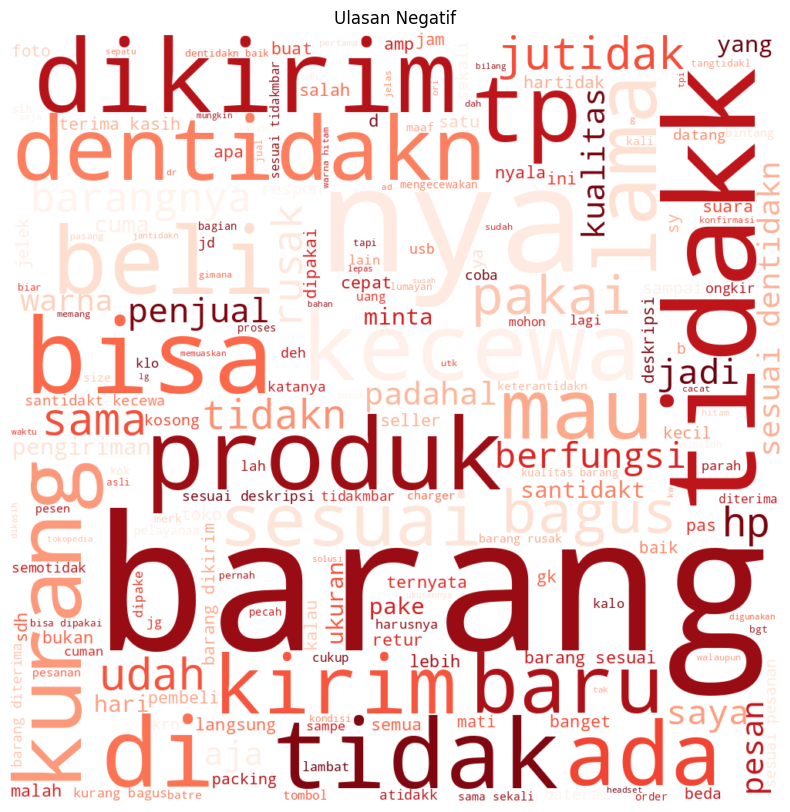

In [ ]:
all_text_s0 = ' '.join(word for word in train_s0["Ulasan"])
wordcloud = WordCloud(colormap='Reds', width=1000, height=1000, mode='RGBA', background_color='white').generate(all_text_s0)
plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.margins(x=0, y=0)
plt.title("Ulasan Negatif")
plt.show()

In [ ]:
train_s1 = df_copy[df_copy["label"] == 1]

In [ ]:
train_s1["Ulasan"] = train_s1["Ulasan"].fillna("Tidak ada komentar")

<ipython-input-55-8c39827972c1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_s1["Ulasan"] = train_s1["Ulasan"].fillna("Tidak ada komentar")


In [ ]:
train_s1.head()

,Unnamed: 0,Ulasan,Rating,Kategori,Nama Produk,Id Produk,Terjual,Id_Toko,Url,label
0,1,barang sesuai pesanan cepat,5,pertukangan,Staples Dekorasi Staples Kayu + Refill 8mm - S...,418660637,1,1740837,https://www.tokopedia.com/shakaonline87/staple...,1
1,2,barang bagus hartidak murah,5,pertukangan,STAPLE GUN ATS 3 WAY TACKER - STAPLES JOK TEMB...,416032545,11,1477109,https://www.tokopedia.com/juraganperkakas/stap...,1
2,3,paket rapi...mantap....cepat....sampe tujuan,5,pertukangan,STAPLE GUN ATS 3 WAY TACKER - STAPLES JOK TEMB...,416032545,11,1477109,https://www.tokopedia.com/juraganperkakas/stap...,1
3,4,saya puas dentidakn barangnya,5,pertukangan,ALAT STAPLES TEMBAK &#40;AIR NAILER GUN&#41; O...,102279869,5,771395,https://www.tokopedia.com/kamarmesin/alat-stap...,1
4,5,responya luar biasa b mantap,5,pertukangan,Isi Refill Staples Jok Kulit Motor / Staple Gu...,190679689,787,969999,https://www.tokopedia.com/mitrapersada/isi-ref...,1


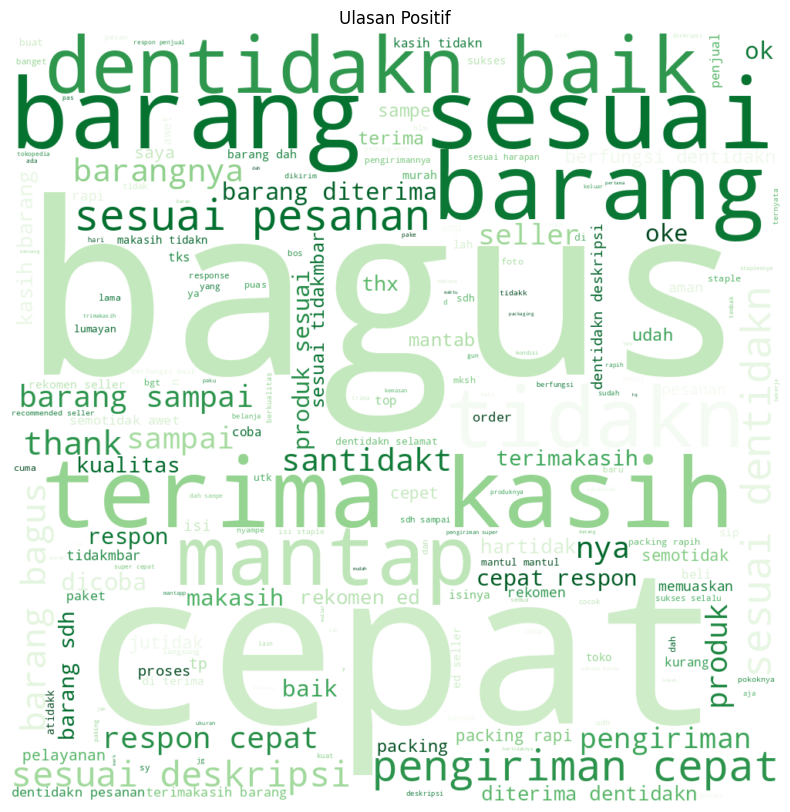

In [ ]:
all_text_s1 = ' '.join(word for word in train_s1["Ulasan"])
wordcloud = WordCloud(colormap="Greens", width=1000, height=1000, mode="RGBA", background_color="white").generate(all_text_s1)
plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Ulasan Positif")
plt.margins(x=0, y=0)
plt.show()

<ipython-input-59-12fda2f5b75d>:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  sentimen_data = pd.value_counts(df_copy["label"], sort=True)


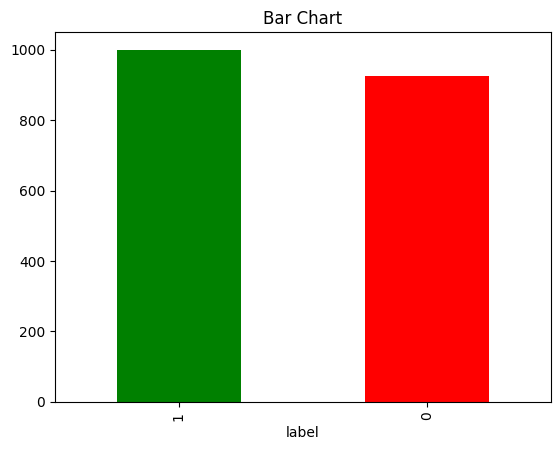

In [ ]:
sentimen_data = pd.value_counts(df_copy["label"], sort=True)
sentimen_data.plot(kind='bar', color=['green', 'red'])
plt.title("Bar Chart")
plt.show()

## G. Split Data (TF-IDF)

In [ ]:
result['Ulasan'] = result['Ulasan'].fillna("Tidak ada komentar")

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(result['Ulasan'], result['label'],
                                                    test_size=0.1, stratify=result['label'], random_state=30)

In [ ]:
import numpy as np

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(decode_error='replace', encoding='utf-8')

In [ ]:
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

print(X_train.shape)
print(X_test.shape)

(1732, 2754)
(193, 2754)


In [ ]:
X_train = X_train.toarray()

In [ ]:
X_test = X_test.toarray()

## G. Machine Learning (Naive Bayes Classifier)

In [ ]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()

In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

cv_method = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=999)

params_NB = {'var_smoothing': np.logspace(0, -9, num=100)}
gscv_nb = GridSearchCV(estimator=nb,
                        param_grid=params_NB,
                        cv = cv_method,
                        verbose = 1,
                        scoring = 'accuracy')

gscv_nb.fit(X_train, y_train)
gscv_nb.best_params_

Fitting 15 folds for each of 100 candidates, totalling 1500 fits


{'var_smoothing': 0.005336699231206307}

In [ ]:
nb = GaussianNB(var_smoothing=0.005336699231206307)

In [ ]:
nb.fit(X_train, y_train)

GaussianNB(var_smoothing=0.005336699231206307)

In [ ]:
y_pred_nb = nb.predict(X_test)

In [ ]:
# proses penyimpan model training
import joblib

joblib.dump(nb, '/content/drive/MyDrive/Colab Notebooks/model_naive_bayes.pkl')
joblib.dump(vectorizer, '/content/drive/MyDrive/Colab Notebooks/vectorizer.pkl')
print("model dan vectorizer berhasil disimpan")

model dan vectorizer berhasil disimpan


## I. Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score

In [ ]:
print('----- confussion matrix -----')
print(confusion_matrix(y_test, y_pred_nb))

print('----- accuracy report -----')
print(accuracy_score(y_test, y_pred_nb))

print('----- classification report -----')
print(classification_report(y_test, y_pred_nb))

----- confussion matrix -----
[[71 22]
 [ 9 91]]
----- accuracy report -----
0.8393782383419689
----- classification report -----
              precision    recall  f1-score   support

           0       0.89      0.76      0.82        93
           1       0.81      0.91      0.85       100

    accuracy                           0.84       193
   macro avg       0.85      0.84      0.84       193
weighted avg       0.84      0.84      0.84       193



## TESTING MODEL

In [53]:
##load testing argument
nb = joblib.load('/content/drive/MyDrive/Colab Notebooks/model_naive_bayes.pkl')
vectorizer = joblib.load('/content/drive/MyDrive/Colab Notebooks/vectorizer.pkl')

##testing model
new_text = input("\nMasukan teks/Rating baru: ")
new_text_vec = vectorizer.transform([new_text]).toarray()
predicted_sentimen = nb.predict(new_text_vec)

if predicted_sentimen[0] == 1:
  sentimen_label = "positif"
elif predicted_sentimen[0] == 0:
  sentimen_label = "negatif"

print("Hasil Analisis Sentimen untuk Text/Rating baru: ", sentimen_label)


Masukan teks/Rating baru: bagus
Hasil Analisis Sentimen untuk Text/Rating baru:  positif
